In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import scipy
import plotly
from plotly import graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
# importing librarys

In [25]:
def parseData(file):
    import csv
    Data =[]
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for lines in csv_reader:
           Data.append(lines)
        mainRootPoints =[]
        c=1
        while len(Data[c]) != 1:
            point = [float(Data[c][0]),float(Data[c][1])]
            mainRootPoints.append(point)
            c= c+1
        pqs =[]
        pq=[]
        c=c+1
        while c < len(Data):
            if len(Data[c]) ==1:
                pqs.append(pq)
                pq =[]
            if len(Data[c]) ==2:
                point = [float(Data[c][0]),float(Data[c][1])]
                pq.append(point)
            c = c+1
        pqs.append(pq)
    return (mainRootPoints, pqs)
#Making the data into readable segments

In [26]:
def plotData(array):
    mainRootPoints = array[0]
    pqs = array[1]
    #print(pqs)
    fig = go.Figure()
    trace= plotPoints(mainRootPoints, "main root")#cell[4]
    fig.add_trace(trace)
    for pq in pqs:
        trace = plotPoints(pq, "lateral root") #cell[4]
        fig.add_trace(trace)
    return (fig)

In [27]:
def plotPoints(points, name):
    xs = []
    ys=[]
    for i in points:
        xs.append(i[0])
        ys.append(i[1])
    trace1 = go.Scatter(x=xs, y = ys, name = name)
    return (trace1)

In [28]:
def findMostOptimal(main, G,al,pq):
    p = pq[0]
    q = pq[1]
    point1 = main[0]
    point2 = main[1]
    CD = 0
    bestDAC = findOptimalInSegment(point1, point2,G,al,pq,CD)# cell[6]
    #returns length, txy, dplot, raplot
    bestLength = bestDAC[0] 
    for i in range(2, len(main)):
        length = findOptimalInSegment(point1, point2,G,al,pq,CD)[0]
        if length < bestLength:
            bestDAC = findOptimalInSegment(point1, point2,G,al,pq,CD)
            #returns length, txy, dplot, raplot,tmax
            bestLength = length
        CD = CD +findOptimalInSegment(point1, point2,G,al,pq,CD)[4] 
        point1 = point2
        point2 = main[i]
    return (bestDAC)

In [29]:
def findOptimalInSegment(point1, point2,G,al,pq,CD):
    a =point1[0]
    b= point1[1]
    c= point2[0]
    d = point2[1]
    p=pq[0]
    q=pq[1]
    theta = findTheta (a,b,c,d) # cell[7]
    ArrayDAC = deAngleCurve(G,al,p,q,theta,a,b,c,d,CD) #cell[8]
    #returns length, txy, dplot, raplot,tmax
    return ArrayDAC

In [30]:
def findTheta (a,b,c,d):
    theta = np.arctan((np.absolute(a-c))/(np.absolute(b-d)))
    m = (b-d)/(a-c)
    if m > 0:
        theta =-theta
    return theta

In [31]:
def deAngleCurve(G,al,p,q,theta,a,b,c,d,CD):
    pq = rotateLine([p],[q], theta, c,d)#cell[9]
    pn = pq[0][0]
    qn = pq[1][0]
    tmax = rotateLine([c],[d], theta, a,b)#cell[9]
    tmax = tmax[1][0]
    best = findBest(tmax, G,pn,qn,al,CD)#cell[10]
    #returns bestLength and bestT
    dPlotA = plotDeAngle(tmax, G, pn ,qn,best[1])#cell[11]
    dPlot = go.Scatter(x = dPlotA[0], y = dPlotA[1], mode= 'lines' , name = str(best[0]))
    raPlotA = reAngle(dPlotA[0], dPlotA[1],theta,c,d) #cell[12]
    raPlot = go.Scatter(x = raPlotA[0], y = raPlotA[1], mode = 'lines', name = str(best[0]))
    txy = reAngle([0],[best[1]], theta,c,d) #cell[12]
    return(best[0], txy, dPlot,raPlot,tmax)

In [32]:
def rotateLine(xs,ys,theta,a,b):
    nx=[]
    ny=[]
    R = [[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]]
    for i in range(0,len(xs)):
        A =[xs[i]-a,ys[i]-b]
        xy=np.array(np.matmul(A,R))
        nx.append(xy[0])
        ny.append(xy[1])
    return(nx, ny)

In [33]:
def findBest(Tmax,G,p,q,a,CD):
    t=0
    Tmax = -Tmax
    bestLength= 100000000000000000000.0
    bestT = t
    while t >= Tmax:
        b = (q - G * (p**2) - t)/p
        if p>0:
            x =np.linspace(0, p, num=50)
        elif p < 0:
            x =np.linspace(p, 0, num=50)
        lot = np.sqrt(1+(2*G*x + ((q-G*(p**2)-t)/p))**2)
        lot = scipy.integrate.trapezoid(lot,x)
        y= a*(lot) +(1-a)*(lot+CD+t)
        length = y
        if length < bestLength:
            bestLength = length
            bestT = t
        t = t - 0.001 #last 
    #print("length: " + str(bestLength) +" t= " + str(bestT))
    return(bestLength,bestT)

In [34]:
def plotDeAngle (tmax,G,p,q,t):
    x = np.linspace(0,p)
    if p <0:
        x = np.linspace(p,0)
    b=(q - G*(p**2) -t)/p
    y=G * x**2 + b*x + t
    return (x,y)

In [35]:
def reAngle(xs, ys, theta, a,b):
    nx =[]
    ny=[]
    R = [[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]]
    inR = np.linalg.inv(R)
    ab= [a,b]
    for i in range(0, len(xs)):
        Ap = [xs[i],ys[i]]
        App = np.matmul(Ap,inR)
        xy=np.array(np.add(App,ab))
        nx.append(xy[0])
        ny.append(xy[1])
    return(nx, ny)

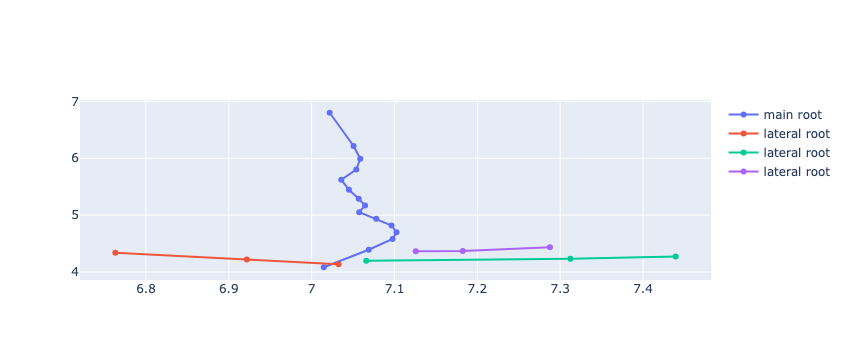

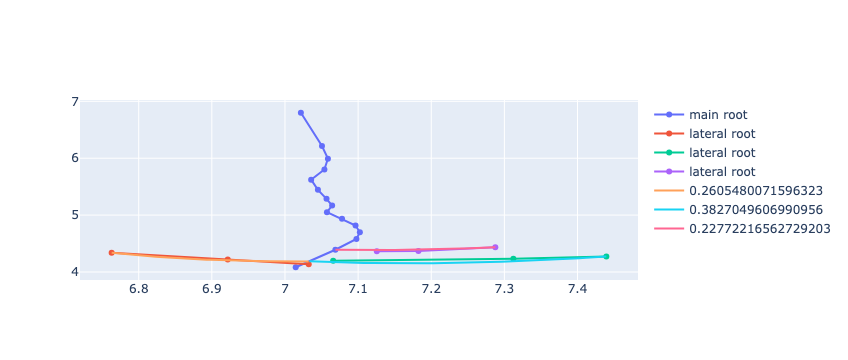

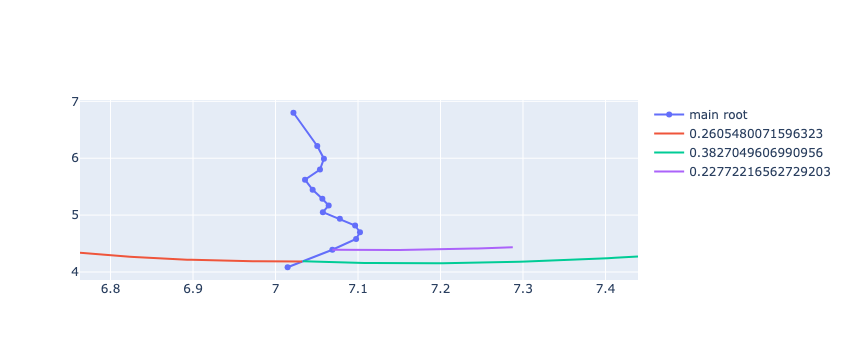

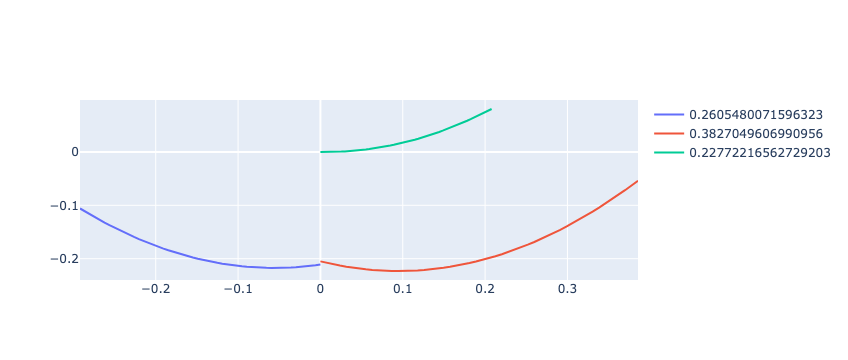

In [36]:
array = parseData('084_4_C_day1.csv') #using cell[2]
#returns [mainrootpoints, lateralRoot points]
fig = plotData(array) #cell[3]
fig.show()
fig2 = go.Figure()
fig3 =go.Figure()
G= 2
al =.7
latteralRoots = array[1]
MainRootPoints = array[0]
trace= plotPoints(MainRootPoints, "main root") #cell[4]
fig2.add_trace(trace)
pqs =[]
Info = [["pq", "length", "txy"]]
for root in latteralRoots:
    pqs.append(root[-1]) #takes the root tip point of each lateral root segment
for pq in pqs:
    DAC = findMostOptimal(MainRootPoints, G,al,pq) #cell[5]
    #returns length, txy, dplot, raplot
    array =[pq, DAC[0], DAC[1]]
    Info.append(array)
    fig.add_trace(DAC[3])
    fig2.add_trace(DAC[3])
    fig3.add_trace(DAC[2])
fig.show()
fig2.show()
fig3.show()
#print(Info)

In [37]:
def readArborFile(fileName):
    # return a networkX graph of the arbor
    pass

In [39]:
def optimalArbor(arbor, G, alpha):
    pass
    # arbor is a networkx graph
    # return a networkx graph representing optimal arbor

In [40]:
def drawArbor(arbor):
    pass
    # arbor is a networkx graph
    # draw the arbor in plotly

In [41]:
x = 2

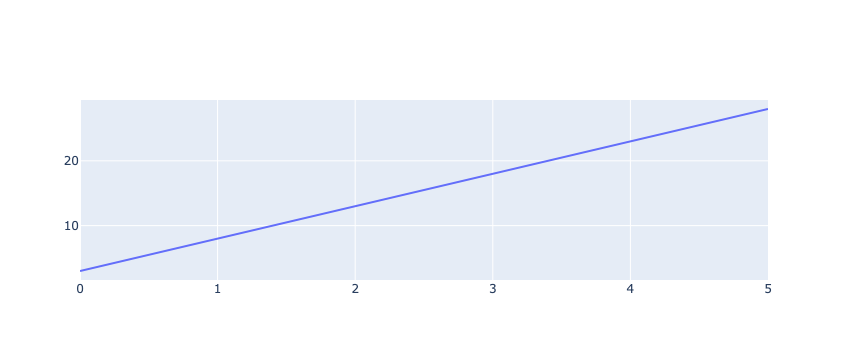

In [42]:
x = np.linspace(0,5)
y = 5*x+3
trace = go.Scatter(x = x, y =y)
fig4 = go.Figure(trace)
fig4.show()
